In [62]:

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.mixed_precision import set_global_policy, Policy

from sklearn.utils import class_weight
import joblib

In [63]:
# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
FINE_TUNE_LEARNING_RATE = 1e-5
EPOCHS = 30
TRAIN_DIR = "../../data5/train"
TEST_DIR = "../../data5/test"

# Enable mixed precision for faster training
policy = Policy('mixed_float16')
set_global_policy(policy)

# Create data generators with VGG16-specific preprocessing
# 2. Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Using the test set as "validation_data" (not ideal practice)
# but shown here due to the 2-folder constraint:
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes
class_labels = list(train_generator.class_indices.keys())

print("Number of classes:", num_classes)
print("Class labels:", class_labels)
# Compute Class Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

Found 5999 images belonging to 4 classes.
Found 2576 images belonging to 4 classes.
Number of classes: 4
Class labels: ['Acne', 'Eczema', 'Infection', 'Malignant']


In [64]:
# 1) Load VGG16 pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# 2) Decide how many layers to freeze
#    VGG16 has 19 layers (if you count the major layers).
#    We'll freeze the first 20 layers and unfreeze the rest.
# Freeze the initial layers
for layer in base_model.layers[:20]:
    layer.trainable = False

# 3) Build a new classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dropout(0.5)(x)  
predictions = Dense(num_classes, activation='softmax', dtype='float32')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,740 (56.14 MB)

 Trainable params: 2,052 (8.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/10


/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 1589s 8s/step - accuracy: 0.2420 - loss: 5.7977 - val_accuracy: 0.3016 - val_loss: 3.0103 - learning_rate: 1.0000e-04
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1576s 8s/step - accuracy: 0.2928 - loss: 4.4560 - val_accuracy: 0.3964 - val_loss: 2.2874 - learning_rate: 1.0000e-04
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1637s 9s/step - accuracy: 0.3402 - loss: 3.7657 - val_accuracy: 0.4678 - val_loss: 1.9828 - learning_rate: 1.0000e-04
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1678s 9s/step - accuracy: 0.3980 - loss: 3.2883 - val_accuracy: 0.5210 - val_loss: 1.7681 - learning_rate: 1.0000e-04
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1704s 9s/step - accuracy: 0.4240 - loss: 2.9853 - val_accuracy: 0.5609 - val_loss: 1.6078 - learning_rate: 1.0000e-04
Epoch 6/10
 24/188 ━━━━━━━━━━━━━━━━━━━━ 19:57 7s/step - accuracy: 0.4825 - loss: 2.4696

In [31]:
for layer in base_model.layers[:10]:
    layer.trainable = False
for layer in base_model.layers[10:]:
    layer.trainable = True
model.compile(
    optimizer=Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-Tune the Model
history_finetune = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1878s 10s/step - accuracy: 0.5873 - loss: 1.0676 - val_accuracy: 0.7050 - val_loss: 0.7274 - learning_rate: 1.0000e-05
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1885s 10s/step - accuracy: 0.6865 - loss: 0.7652 - val_accuracy: 0.7321 - val_loss: 0.6703 - learning_rate: 1.0000e-05
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1980s 11s/step - accuracy: 0.7285 - loss: 0.6669 - val_accuracy: 0.7519 - val_loss: 0.6463 - learning_rate: 1.0000e-05
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3635s 19s/step - accuracy: 0.7582 - loss: 0.6140 - val_accuracy: 0.7655 - val_loss: 0.5981 - learning_rate: 1.0000e-05
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3687s 20s/step - accuracy: 0.7712 - loss: 0.5707 - val_accuracy: 0.7783 - val_loss: 0.5649 - learning_rate: 1.0000e-05
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3706s 20s/step - accuracy: 0.7955 - loss: 0.5193 - val_accuracy: 0.7791 - val_loss: 0.6084 - learning_rate: 1.0000e-05
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3647s 

In [ ]:
def plot_training_results(history, metrics=["accuracy", "loss"]):
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_training_results(history, metrics=["accuracy", "loss"])

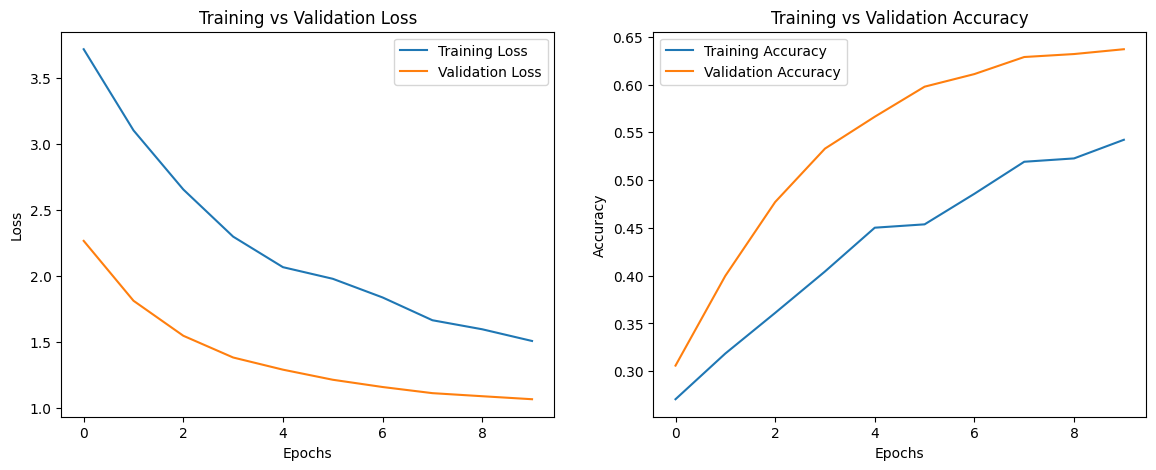

In [33]:
train_loss = history.history['loss']
train_acc  = history.history['accuracy']
val_loss   = history.history['val_loss']
val_acc    = history.history['val_accuracy']

epochs_range = range(len(train_loss))

plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss,   label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc,   label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [34]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Test Loss: 0.5085420608520508
Test Accuracy: 0.8105590343475342


In [35]:
train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)


Train Loss: 0.30892133712768555
Train Accuracy: 0.8891481757164001


81/81 ━━━━━━━━━━━━━━━━━━━━ 452s 6s/step

Classification Report:
              precision    recall  f1-score   support

        Acne       0.91      0.89      0.90       626
      Eczema       0.72      0.79      0.75       650
   Infection       0.70      0.69      0.70       650
   Malignant       0.94      0.87      0.90       650

    accuracy                           0.81      2576
   macro avg       0.82      0.81      0.81      2576
weighted avg       0.82      0.81      0.81      2576

Confusion Matrix:
[[559  26  34   7]
 [ 16 515 106  13]
 [ 33 148 451  18]
 [  7  28  52 563]]


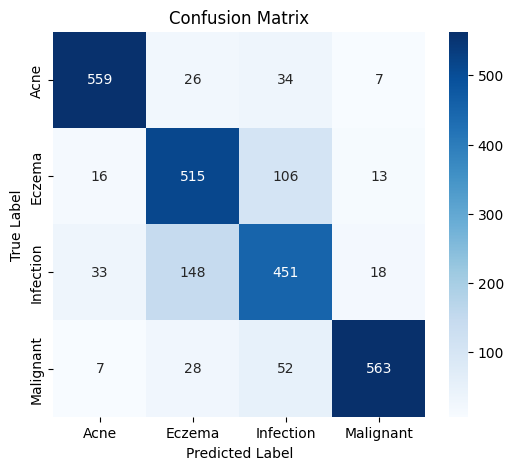

In [36]:
# Predict class probabilities
y_pred_probs = model.predict(test_generator)
# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels from the test generator
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [37]:
# 6. Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Val Loss:", test_loss)
print("Val Accuracy:", test_accuracy)

81/81 ━━━━━━━━━━━━━━━━━━━━ 454s 6s/step - accuracy: 0.8452 - loss: 0.4614
Val Loss: 0.5085420608520508
Val Accuracy: 0.8105590343475342


Macro-average ROC AUC: 0.9529460172614304
Micro-average ROC AUC: 0.9592564858528477


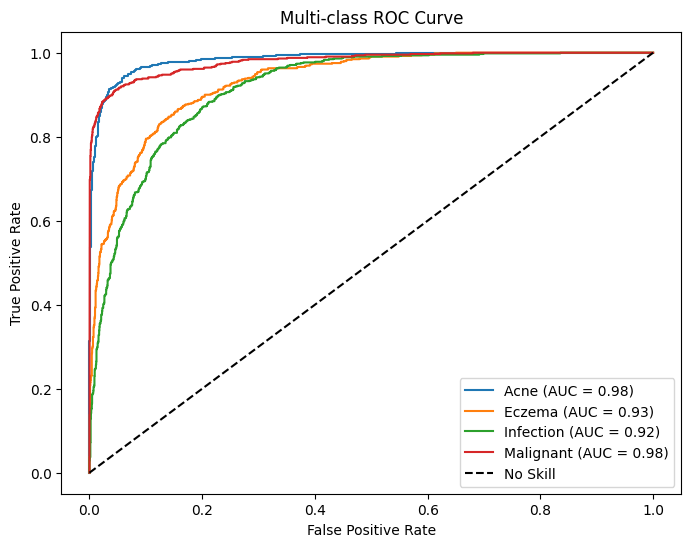

In [40]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
y_true_indices = test_generator.classes

# 8. Multi-class ROC & AUC
y_true_binarized = label_binarize(y_true_indices, classes=range(num_classes))

macro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='macro')
micro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='micro')
print("Macro-average ROC AUC:", macro_roc_auc)
print("Micro-average ROC AUC:", micro_roc_auc)

fpr = {}
tpr = {}
roc_auc_classwise = {}

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc_classwise[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label='{} (AUC = {:.2f})'.format(class_labels[i], roc_auc_classwise[i]))

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [41]:
model.save("../../models/hybrid_model_vgg16_new1.keras")

In [50]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle

# Constants
BATCH_SIZE = 32  # Replace with your actual batch size
MODEL_SAVE_PATH = '../../models/hybrid_rf_vgg16_model_7030.pkl'  # Path to save the model

# Function to Extract Features and Labels
def extract_features_and_labels(generator, base_model, batch_size):
    features = []
    labels = []
    for batch_images, batch_labels in generator:
        features.append(base_model.predict(batch_images, verbose=0))  # Extract features
        labels.append(batch_labels)
        # Stop when all samples are processed
        if len(features) * batch_size >= generator.samples:
            break
    features = np.vstack(features)  # Stack features vertically
    labels = np.vstack(labels)      # Stack labels vertically
    return features, labels

# Step 1: Extract Features and Labels from Training Data
print("Extracting features and labels for training...")
train_features, train_labels = extract_features_and_labels(train_generator, base_model, BATCH_SIZE)

# Extract Features and Labels from Test Data
print("Extracting features and labels for testing...")
test_features, test_labels = extract_features_and_labels(test_generator, base_model, BATCH_SIZE)

# Step 2: Convert One-Hot Encoded Labels to Integers
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

# Step 3: Flatten Features for Random Forest
print("Flattening features for Random Forest...")
X_train = train_features.reshape(train_features.shape[0], -1)
X_test = test_features.reshape(test_features.shape[0], -1)

# Step 4: Define and Train Random Forest with Grid Search
print("Training Random Forest with Grid Search...")
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, train_labels)

# Get the best model from grid search
best_rf = grid_search.best_estimator_

# Step 5: Evaluate the Model
print("Evaluating the model...")
y_pred = best_rf.predict(X_test)

print("Classification Report:")
print(classification_report(test_labels, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred))

# Step 6: Save the Model
print(f"Saving the model to {MODEL_SAVE_PATH}...")
with open(MODEL_SAVE_PATH, 'wb') as file:
    pickle.dump(best_rf, file)

print("Model saved successfully.")


Extracting features and labels for training...
Extracting features and labels for testing...
Flattening features for Random Forest...
Training Random Forest with Grid Search...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Evaluating the model...
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       626
           1       0.70      0.75      0.72       650
           2       0.65      0.67      0.66       650
           3       0.94      0.83      0.88       650

    accuracy                           0.78      2576
   macro avg       0.79      0.78      0.78      2576
weighted avg       0.79      0.78      0.78      2576

Confusion Matrix:
[[552  22  44   8]
 [ 30 486 120  14]
 [ 42 161 435  12]
 [  8  27  75 540]]
Saving the model to ../../models/hybrid_rf_vgg16_model_7030.pkl...
Model saved successfully.


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128)  # Dimensionality reduction

# Flatten the data
X_train_flat = train_features.reshape(X_train.shape[0], -1)
X_test_flat = test_features.reshape(X_test.shape[0], -1)
train_features_pca = pca.fit_transform(X_train_flat)
val_features_pca = pca.transform(X_test_flat)

pca_model_path = "../../models/vgg7030_pca_model.pkl"
joblib.dump(pca, pca_model_path)

['../../models/vgg7030_pca_model.pkl']

In [54]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle

# Constants
BATCH_SIZE = 32  # Replace with your actual batch size
MODEL_SAVE_PATH = '../../models/hybrid_knn_vgg16_model_7030.pkl'  # Path to save the model

# Function to Extract Features and Labels
def extract_features_and_labels(generator, base_model, batch_size):
    features = []
    labels = []
    for batch_images, batch_labels in generator:
        features.append(base_model.predict(batch_images, verbose=0))  # Extract features
        labels.append(batch_labels)
        # Stop when all samples are processed
        if len(features) * batch_size >= generator.samples:
            break
    features = np.vstack(features)  # Stack features vertically
    labels = np.vstack(labels)      # Stack labels vertically
    return features, labels

# Step 1: Extract Features and Labels from Training Data
print("Extracting features and labels for training...")
train_features, train_labels = extract_features_and_labels(train_generator, base_model, BATCH_SIZE)

# Extract Features and Labels from Test Data
print("Extracting features and labels for testing...")
test_features, test_labels = extract_features_and_labels(test_generator, base_model, BATCH_SIZE)

# Step 2: Convert One-Hot Encoded Labels to Integers
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

# Step 3: Flatten Features for KNN
print("Flattening features for KNN...")
X_train = train_features.reshape(train_features.shape[0], -1)
X_test = test_features.reshape(test_features.shape[0], -1)

# Step 4: Define and Train KNN with Grid Search
print("Training KNN with Grid Search...")
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, train_labels)

# Get the best model from grid search
best_knn = grid_search.best_estimator_

# Step 5: Evaluate the Model
print("Evaluating the model...")
y_pred = best_knn.predict(X_test)

print("Classification Report:")
print(classification_report(test_labels, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred))

# Step 6: Save the Model
print(f"Saving the model to {MODEL_SAVE_PATH}...")
with open(MODEL_SAVE_PATH, 'wb') as file:
    pickle.dump(best_knn, file)

print("Model saved successfully.")


Extracting features and labels for training...
Extracting features and labels for testing...
Flattening features for KNN...
Training KNN with Grid Search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Evaluating the model...
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.56      0.69       626
           1       0.42      0.70      0.53       650
           2       0.47      0.44      0.45       650
           3       0.96      0.77      0.85       650

    accuracy                           0.62      2576
   macro avg       0.69      0.62      0.63      2576
weighted avg       0.69      0.62      0.63      2576

Confusion Matrix:
[[348 189  86   3]
 [  9 454 182   5]
 [ 17 337 285  11]
 [  3  96  52 499]]
Saving the model to ../../models/hybrid_knn_vgg16_model_7030.pkl...
Model saved successfully.
